<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#User-Guide-on-linear-example" data-toc-modified-id="User-Guide-on-linear-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>User Guide on linear example</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#DFS-with-fixed-hyper-parameters" data-toc-modified-id="DFS-with-fixed-hyper-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DFS with fixed hyper-parameters</a></span></li><li><span><a href="#Selection-of-$s$" data-toc-modified-id="Selection-of-$s$-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Selection of $s$</a></span></li></ul></li></ul></div>

# Deep Feature Selection
In this notebook, we will demonstrate how to implement our method on the linear simulation examples from our paper.
## User Guide on linear example
In this example, a high dimensional dataset with 1000 covariates and 500 observations is generated using the linear system:
$$y = X\beta + \epsilon$$
where $\beta \in \mathbb{R}^{1000}$, but only the first 100 elements of $\beta$ is non-zero. Our task is to correctly select the important variables. Please see section 5.1 of the paper for detailed generation process.

In [1]:
import sys
sys.path.append("../../src")
from time import clock
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
from torch.nn.parameter import Parameter
from utils import data_load_l, measure, mse
from models import Net_linear
from dfs import DFS_epoch, training_l

### Data Preparation
We will load our data in the following chunk. 

The data, both covariates and response, need to be load as `pytorch` `Tensor` objects to be fed in to DFS algorithm. 

The covariates matrix of training set need to be $\sqrt{n}$ column-wise normalized, $n$ is the sample size, i.e. summation of square of each column is $n$. 

The covariates matrix of testing set also need to be normalized correspondingly, i.e. divided by the some normalization constant of the training set. The function `data_load_l` will automatically read in dataset, normalizing, and split the dataset into training and test set.

In [2]:
# load and prepare datasets
dirc = "../../data/linear/p_1000_N_1000_s_100/"
k = 0 # dataset number from 0 to 9
X, Y, X_test, Y_test, supp_true = data_load_l(k, directory=dirc)
N, p = X.shape
print("The covariates is of type:", type(X))
print("The response is of type:", type(Y))
print()
print("The dimension of training set:", X.shape)
print("    The sum square of the first 5 columns:")
print("    ", torch.sum(X**2, dim=0)[:5])
print()
print("The dimension of test set:", X_test.shape)
print("    The sum square of the first 5 columns:")
print("    ", torch.sum(X_test**2, dim=0)[:5])

The covariates is of type: <class 'torch.Tensor'>
The response is of type: <class 'torch.Tensor'>

The dimension of training set: torch.Size([500, 1000])
    The sum square of the first 5 columns:
     tensor([499.9998, 500.0001, 500.0001, 499.9999, 499.9999])

The dimension of test set: torch.Size([500, 1000])
    The sum square of the first 5 columns:
     tensor([467.6035, 536.6000, 467.3558, 435.5148, 476.9774])


As displayed above, all columns of training set covariates matrix are normalized. The columns of test set covariates matrix is normalized by constant of training set, thus their sum square of columns are not unified. But since training set and test set follows the same distribution, they have very similar sum squares.

### DFS with fixed hyper-parameters
In this section, we demonstrate how to run DFS with one given set of hyper-parameters. The hyper-parameters includes:
* `s`, the number of variables to be selected;
* `c`, the tunning parameters to control the magnitude of $\lambda_1$ and $\lambda_2$;
* `epochs`, the number of DFS iterations to be run;
* `n_hidden1`, the number of neurons in the fully connect neural networks;
* `learning_rate`, the learning rate for optimizer;
* `Ts` & `step`, the parameters to control the optimization on given support

Among the above hyper-parameters, `s` is the most important parameters, and the selection of $s$ will be demonstrated in next section. `c` can be selection through a sequence of candidates that returns the smallest loss function. Others mostly are meant to help the convergence of the optimization steps.

In [3]:
# specify hyper-paramters
s = 100
c = 1
epochs = 3 # We reduced the number of epochs in notebooks
n_hidden1 = 1
learning_rate = 0.001
Ts = 1000
step = 1

# Define Model
torch.manual_seed(1) # set seed 
# Define a model with pre-specified structure and hyper parameters
model = Net_linear(n_feature=p, n_hidden1=n_hidden1, n_output=1)
# Define another model to save the current best model based on loss function value
# The purpose is to prevent divergence of the training due to large learning rate or other reason
best_model = Net_linear(n_feature=p, n_hidden1=n_hidden1, n_output=1)

# Define optimizers for the optimization with given support
# optimizer to separately optimize the hidden layers and selection layers
# the selection layer will be optimized on given support only.
# the optimzation of hidden layers and selection layer will take turn in iterations
optimizer = torch.optim.SGD(list(model.parameters()), lr=learning_rate, weight_decay=0.0025*c)
optimizer0 = torch.optim.SGD(model.hidden0.parameters(), lr=learning_rate, weight_decay=0.0005*c)

# Define loss function
lf = torch.nn.MSELoss()

# Allocated some objects to keep track of changes over iterations
hist = []
SUPP = []
supp_x = list(range(p)) # initial support
SUPP.append(supp_x)

### DFS algorithm
start = clock()
for i in range(epochs):
    # One DFS epoch
    model, supp_x, _ = DFS_epoch(model, s, supp_x, X, Y, lf, optimizer0, optimizer, Ts, step)
    supp_x.sort()
    # Save current loss function value and support
    hist.append(lf(model(X), Y).data.numpy().tolist())
    SUPP.append(supp_x)
    # Prevent divergence of optimization over support, save the current best model
    if hist[-1] == min(hist):
        best_model.load_state_dict(model.state_dict())
        best_supp = supp_x
    # Early stop criteria
    if len(SUPP[-1]) == len(SUPP[-2]) and len(set(SUPP[-1]).difference(SUPP[-2])) == 0:
        break

end = clock()
print("Training finished in", len(SUPP)-1, "epochs, and took", end-start, "seconds")

Training finished in 3 epochs, and took 988.65 seconds


In the following chunk, we will demonstrate the results from the DFS algorithm, in terms of selected support, number of missed or false selected support, training mse and test mse for __one step__ procedure.

In [4]:
### metrics calculation
fs = set(best_supp).difference(supp_true) # false selection number
ns = set(supp_true).difference(best_supp) # negative selection number
_err_train = mse(best_model, X, Y) # training error
_err_test = mse(best_model, X_test, Y_test) # testing error

print("The support selected is:", best_supp)
print("The index of non-zero coefficients on selection layer:",
      np.where(best_model.hidden0.weight != 0)[0])
print()
print("False selected variables:", fs)
print("Missed variables:", ns)
print()
print("The training mse of one step is:", _err_train)
print("The test mse of one step is:", _err_test)

The support selected is: [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  97  98  99 100 491 853]
The index of non-zero coefficients on selection layer: [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  97  98  99 100 491 853]

False selected variables: {100, 853, 491}
Missed variables: {96, 58, 13}

The training mse of one step is

From the results above, we have successfully selected most of the important variables without knowing the underling model and with the presence of correlation between variables.

In the following chunk, we will perform a two-step procedure to train the `best_model` on the given support.

Two-step procedure is used for two reasons, to get better predictive performance and to get better estimation of $bic$ which is important in selection of optimal s .

As we demonstrated on the above chunk, the selection layer of `best_model` has non-zero coefficients on given support. In the second step, we treat `best_model` as our initial model and update parameters only in hidden layer.

In [5]:
# Define optimizer only update parameters in hidden layer.
_optimizer = torch.optim.Adam(list(best_model.parameters())[1:], lr=0.5)
for _ in range(5000):
    out = best_model(X)
    loss = lf(out, Y)
    _optimizer.zero_grad()
    loss.backward()
    _optimizer.step()
    hist.append(loss.data.numpy().tolist())

### metric calculation
mse_train = mse(best_model, X, Y)
mse_test = mse(best_model, X_test, Y_test)
print("The training mse of two step is:", mse_train)
print("The test mse of two step is:", mse_test)

The training mse of two step is: 1.1326223611831665
The test mse of two step is: 1.2946219444274902


The result has shown that the predictive performance of our model is significantly increased. 

All good results shown above is based on the correct given $s$. However, in reality, $s$ is unknown for most of the time. So the next thing would be finding the optimal $s$

### Selection of $s$
In this section, we demonstrate the procedure of selection of optimal $s$. We have wrapped up the training procedure above in a function `training_l`. For each given $s$,  $bic$, defined as $n \cdot \log \hat{\sigma}^2 + c \cdot s \cdot \log n$, of the model will be automatically calculated by `training_l`, also the trained model with the given $s$ will also be returned.

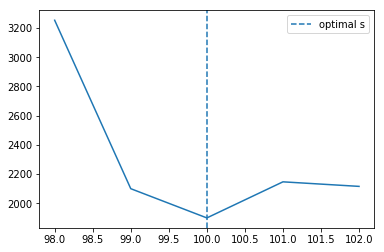

In [6]:
Ss = [98, 99, 100, 101, 102]
BIC = []
for i, s in enumerate(Ss):
    model, supp, bics, [err_train, err_test], _, _, _ = training_l(X, Y, X_test, Y_test, supp_true, c, s,
                                                                   epochs=3, Ts=1000)
    BIC.append(bics[1])
    if bics[1] == min(BIC):
        best_model = model
        best_supp = supp
        best_err_train, best_err_test = err_train, err_test


idx = np.argmin(BIC)
best_s = Ss[idx]
plt.plot(Ss, BIC)
plt.axvline(x=best_s, ls='--', label="optimal s")
plt.legend()
plt.show()

From the graph above, we can tell $s=100$ is the optimal $s$, and the corresponding model is stored in `best_model` whose performance is shown below:

In [7]:
fs = set(best_supp).difference(supp_true)
ns = set(supp_true).difference(best_supp)
mse_train = mse(best_model, X, Y)
mse_test = mse(best_model, X_test, Y_test)
print("Number of false selected variables:", fs)
print("Number of missed variables:", ns)

print("The training mse of best model based on optimal s is:", mse_train)
print("The test mse of best model based on optimal s is:", mse_test)

Number of false selected variables: {100, 853, 491}
Number of missed variables: {96, 58, 13}
The training mse of best model based on optimal s is: 1.1326223611831665
The test mse of best model based on optimal s is: 1.2946219444274902
